# DM-40905 : fix generateDonutFromRefitWcsTask 

https://tssw-ci.lsst.org/job/LSST_Telescope-and-Site/job/ts_wep/job/develop/836/consoleFull


* `lsst_distrib` : w2023_38
* `ts_wep` : 6.4.9

`test_generateDonutFromRefitWcsTask.TestGenerateDonutFromRefitWcsTask` : 

In [1]:
import logging
import os
import unittest
from copy import copy

import lsst.afw.image as afwImage
import numpy as np
import pandas
from lsst.daf import butler as dafButler
from lsst.ts.wep.task import (
    DonutStamps,
    GenerateDonutFromRefitWcsTask,
    GenerateDonutFromRefitWcsTaskConfig,
    RefCatalogInterface,
)
from lsst.ts.wep.utility import (
    getModulePath,
    runProgram,
    writeCleanUpRepoCmd,
    writePipetaskCmd,
)



INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Run ISR and generateDonutDirectDetect so that we have the prerequisite data products

In [4]:
#def setUpClass(cls):
"""
Run the pipeline once so we can test outputs in
multiple tests.
"""

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
runName = "run111"

# Check that run doesn't already exist due to previous improper cleanup
butler = dafButler.Butler(repoDir)
registry = butler.registry
collectionsList = list(registry.queryCollections())
if runName in collectionsList:
    cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)
    runProgram(cleanUpCmd)

collections = "refcats/largeCatSingleCCD,LSSTCam/calib,LSSTCam/raw/all"
instrument = "lsst.obs.lsst.LsstCam"
cameraName = "LSSTCam"
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testDonutFromRefitWcsPipeline.yaml"
)
exposureId = 4021123106008  # Exposure ID for test extra-focal image

pipeCmd = writePipetaskCmd(
   repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml
)
# Update task configuration to match pointing information
pipeCmd += f" -d 'exposure IN ({exposureId}, {exposureId+1})'"
runProgram(pipeCmd)


lsst.pipe.base.quantum_graph_builder INFO: Processing pipeline subgraph 1 of 1 with 5 task(s).
lsst.pipe.base.quantum_graph_builder INFO: Iterating over query results to associate quanta with datasets.
lsst.pipe.base.quantum_graph_builder INFO: Initial bipartite graph has 9 quanta, 46 dataset nodes, and 50 edges from 2 query row(s).
lsst.pipe.base.quantum_graph_builder INFO: Generated 2 quanta for task isr.
lsst.pipe.base.quantum_graph_builder INFO: Generated 2 quanta for task generateDonutDirectDetectTask.
lsst.pipe.base.quantum_graph_builder INFO: Generated 2 quanta for task generateDonutFromRefitWcsTask.
lsst.pipe.base.quantum_graph_builder INFO: Generated 1 quantum for task cutOutDonutsScienceSensorTask.
lsst.pipe.base.quantum_graph_builder INFO: Generated 2 quanta for task calcZernikesTask.
lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 9 quanta for 5 tasks, graph ID: '1695762219.82716-639792'
Quanta             Tasks            
------ -----------------------------
     

lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'generateDonutFromRefitWcsTask' on quantum {instrument: 'LSSTCam', detector: 94, visit: 4021123106009, ...} took 2.701 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 5 quanta successfully, 0 failed and 4 remain out of total 9 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=generateDonutFromRefitWcsTask dataId={instrument: 'LSSTCam', detector: 94, visit: 4021123106008, ...}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Constructing task and executing quantum for label=generateDonutFromRefitWcsTask dataId={instrument: 'LSSTCam', detector: 94, visit: 4021123106008, ...}.
py.warnings WARNING: /sdf/group/rubin/sw/conda/envs/lsst-scipipe-7.0.1/share/eups/Linux64/pipe_base/g655761b648+94da4844e8/python/lsst/pipe/base/pipelineTask.py:185: UserWarning: Reading file:///sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/gen3TestRepo/run111/preFitPostISRCCD/20211231/

In [ ]:
## Aside: 

In [8]:
pipelineYaml

'/sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testDonutFromRefitWcsPipeline.yaml'

In [6]:
pipeCmd

"pipetask run -b /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/gen3TestRepo -i refcats/largeCatSingleCCD,LSSTCam/calib,LSSTCam/raw/all --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run run111 -p /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testDonutFromRefitWcsPipeline.yaml -d 'exposure IN (4021123106008, 4021123106009)'"

ok, obviously running it as a pipetask fails. Can I learn anything more by running it from the notebook. Follow https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/aos/closed_loop/genDonutCatsWithRefitWcs.ipynb 

In [2]:
import lsst.geom
from lsst.daf.butler import Butler
from lsst.ts.wep.task import GenerateDonutDirectDetectTaskConfig, GenerateDonutDirectDetectTask
from lsst.ts.wep.task import RefCatalogInterface
from lsst.meas.algorithms import ReferenceObjectLoader, LoadReferenceObjectsConfig
from lsst.ts.wep.task import GenerateDonutFromRefitWcsTask, GenerateDonutFromRefitWcsTaskConfig
from lsst.ts.wep.task import GenerateDonutCatalogWcsTask, GenerateDonutCatalogWcsTaskConfig


Load the postISR images from the task that we've just run:

In [3]:
moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
repoDir = os.path.join(testDataDir, "gen3TestRepo")

repo_dir = repoDir

In [4]:
butler = Butler(repo_dir)

Find out what is available in that butler:

In [12]:
registry = butler.registry

collectionsList = list(registry.queryCollections())

In [13]:
collectionsList

['LSSTCam/raw/all',
 'refcats/gen2',
 'LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'LSSTComCam/calib',
 'LSSTComCam/calib/unbounded',
 'refcats/largeCatSingleCCD',
 'run111']

In [22]:
list(registry.queryDatasetTypes())

[DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('cal_ref_cat', {htm7}, SimpleCatalog),
 DatasetType('camera', {instrument}, Camera, isCalibration=True),
 DatasetType('packages', {}, Packages),
 DatasetType('generateDonutDirectDetectTask_config', {}, Config),
 DatasetType('fitWcsTask_config', {}, Config),
 DatasetType('isr_config', {}, Config),
 DatasetType('preFitPostISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('directDetectDonutCatalog', {band, instrument, detector, physical_filter, visit}, DataFrame),
 DatasetType('generateDonutDirectDetectTask_metadata', {band, instrument, detector, physical_filter, visit}, TaskMetadata),
 DatasetType('generateDonutDirectDetectTask_log', {band, instrument, detector, physical_filter, visit}, ButlerLogRecords),
 DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure),
 DatasetType('fitWcsTask_metadata', {band, instrume

In [7]:
output_collection = 'run111'
data_id_intra = {'instrument': 'LSSTCam', 'exposure': 4021123106008, 'visit': 4021123106008, 'detector': 94}
data_id_extra = {'instrument': 'LSSTCam', 'exposure': 4021123106009, 'visit': 4021123106009, 'detector': 93}
postIsrExtra = butler.get('preFitPostISRCCD', dataId=data_id_intra, collections=output_collection)

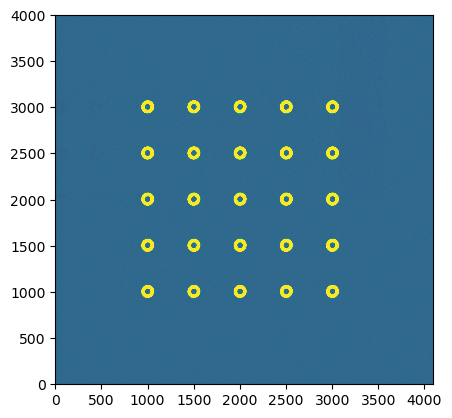

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
data = postIsrExtra.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, origin='lower')

So there's plenty of donuts ... Now show the donuts detected via direct detect: 

In [12]:
donutCatalog = butler.get('directDetectDonutCatalog', dataId=data_id_intra, collections=output_collection)

Text(0, 0.5, 'Y Pixels')

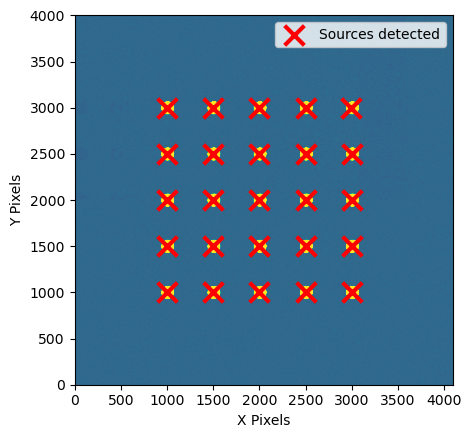

In [25]:

data = postIsrExtra.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, origin='lower')
plt.scatter(donutCatalog['centroid_x'], donutCatalog['centroid_y'], 
            c='r', marker='x', lw=3, s=200, label="Sources detected")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

ok, so obviously all donuts get detected by this task. How about the next step... I take the configs from `/sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testDonutFromRefitWcsPipeline.yaml`  : 

In [37]:
fitConfig = GenerateDonutFromRefitWcsTaskConfig()
fitConfig.connections.astromRefCat = 'cal_ref_cat'
fitConfig.connections.photoRefCat = 'cal_ref_cat'
fitConfig.astromTask.referenceSelector.doMagLimit  = False
fitConfig.donutSelector.unblendedSeparation = 1 
fitConfig.astromTask.referenceSelector.magLimit.fluxField = 'g_flux'



In [39]:

fitTask = GenerateDonutFromRefitWcsTask(config=fitConfig)

Get the astrometric reference catalog: 

In [9]:
# Initialize with pointing information
info = postIsrExtra.getInfo()
visitInfo = info.getVisitInfo()
boresightRa, boresightDec = visitInfo.boresightRaDec
boresightRotAng = visitInfo.boresightRotAngle

refCatInterface = RefCatalogInterface(boresightRa.asDegrees(), 
                                      boresightDec.asDegrees(), 
                                      boresightRotAng.asDegrees())

In [13]:
htmIds = refCatInterface.getHtmIds()
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
#refCatButler = Butler('/sdf/data/rubin/repo/main/')
# Use Gaia for astrometry tasks
catalogName = 'cal_ref_cat'
collections = ['refcats/largeCatSingleCCD']
dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)

In [19]:
refCatConfig = LoadReferenceObjectsConfig(anyFilterMapsToThis='g')

In [20]:
refCatLoader = ReferenceObjectLoader(dataIds, dataRefs, )config=refCatConfig)
refCat = refCatLoader.loadSkyCircle(visitInfo.boresightRaDec, lsst.geom.Angle(0.01), 'g')

INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [359.42703963, 0.57296037], [-0.57295951, 0.57295951] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 25 reference objects


In [35]:
t = refCat.refCat.asAstropy()

In [40]:
t[:4]

id,coord_ra,coord_dec,g_flux,anyFilterMapsToThis,g_fluxErr,anyFilterMapsToThisErr,coord_raErr,coord_decErr
,rad,rad,nJy,nJy,nJy,nJy,rad,rad
int64,float64,float64,float64,float64,float64,float64,float32,float32
15,0.00048335148304730965,-0.0010156769049055802,3630780.5477010026,3630780.5477010026,nan,nan,nan,nan
16,0.00048335148304730965,-0.0005308767985791152,3630780.5477010026,3630780.5477010026,nan,nan,nan,nan
17,0.00048335148304730965,-4.605923896013036e-05,3630780.5477010026,3630780.5477010026,nan,nan,nan,nan
20,0.0009681690426662945,-0.0010156769049055802,3630780.5477010026,3630780.5477010026,nan,nan,nan,nan


Use the same as the photometric reference catalog: 

In [18]:
postIsrExtra.filter.bandLabel

'g'

# Run GenerateDonutFromRefitWcsTask with LSSTCam test data 

Minimum working example:

- setup butler
- read postIsr image
- read the direct detect donut catalog 
- 

In [22]:
from lsst.daf.butler import Butler
from lsst.ts.wep.task import RefCatalogInterface
from lsst.ts.wep.task import GenerateDonutFromRefitWcsTask, GenerateDonutFromRefitWcsTaskConfig
from lsst.ts.wep.utility import  getModulePath
from copy import copy

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
butler = Butler(repoDir)


output_collection = 'run111'
data_id_intra = {'instrument': 'LSSTCam', 'exposure': 4021123106008, 'visit': 4021123106008, 'detector': 94}
data_id_extra = {'instrument': 'LSSTCam', 'exposure': 4021123106009, 'visit': 4021123106009, 'detector': 93}
postIsrExtra = butler.get('preFitPostISRCCD', dataId=data_id_intra, collections=output_collection)

donutCatalog = butler.get('directDetectDonutCatalog', dataId=data_id_intra, collections=output_collection)





        
        
fitConfig = GenerateDonutFromRefitWcsTaskConfig()
fitConfig.connections.astromRefCat = 'cal_ref_cat'
fitConfig.connections.photoRefCat = 'cal_ref_cat'
#fitConfig.astromTask.referenceSelector.doMagLimit  = False
fitConfig.donutSelector.unblendedSeparation = 1 
fitConfig.astromTask.referenceSelector.magLimit.fluxField = 'g_flux'
fitConfig.astromTask.referenceSelector.magLimit.maximum = 16.0


fitTask = GenerateDonutFromRefitWcsTask(config=fitConfig)


        
info = postIsrExtra.getInfo()
visitInfo = info.getVisitInfo()
boresightRa, boresightDec = visitInfo.boresightRaDec
boresightRotAng = visitInfo.boresightRotAngle

refCatInterface = RefCatalogInterface(boresightRa.asDegrees(), 
                                      boresightDec.asDegrees(), 
                                      boresightRotAng.asDegrees())

htmIds = refCatInterface.getHtmIds()
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo 
# for the catalog pieces we want

catalogName = 'cal_ref_cat'
collections = ['refcats/largeCatSingleCCD']
dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)


out = fitTask.run(dataRefs, copy(postIsrExtra), donutCatalog, dataRefs)

INFO:lsst.generateDonutFromRefitWcsTask.astromTask:Purged 0 sources, leaving 25 good sources
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [0.00000000, 360.00000000], [-0.13322201, 0.13322201] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 25 reference objects
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.referenceSelector:Selected 25/25 references
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.matcher:Matched 12 sources
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.matcher:Matched 12 sources
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.matcher:Matched 12 sources
INFO:lsst.generateDonutFromRefitWcsTask.astromTask:Matched and fit WCS in 3 iterations; found 12 matches with mean and scatter = 0.025 +- 0.009 arcsec
INFO:lsst.generateDonutFromRefitWcsTask:Running Donut Selector
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading ref

In [23]:
fitWcs = out.outputExposure.wcs
fitCatalog = out.donutCatalog

In [24]:
import numpy as np 
directDetectCat = donutCatalog

# Shift the WCS by a known amount
truePixelShift = 5
directDetectCat["centroid_x"] += truePixelShift
directDetectCat["centroid_y"] += truePixelShift
postIsrExtra = butler.get('preFitPostISRCCD', dataId=data_id_intra, collections=output_collection)

shiftedOutput = fitTask.run(
    dataRefs, copy(postIsrExtra), directDetectCat, dataRefs
)
shiftedWcs = shiftedOutput.outputExposure.wcs
shiftedCatalog = shiftedOutput.donutCatalog

# Get the shifts out of the new WCS
fitPixelOrigin = np.array(fitWcs.getPixelOrigin())
shiftedPixelOrigin = np.array(shiftedWcs.getPixelOrigin())
pixelShift = fitPixelOrigin - shiftedPixelOrigin


INFO:lsst.generateDonutFromRefitWcsTask.astromTask:Purged 0 sources, leaving 25 good sources
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [0.00000000, 360.00000000], [-0.13322201, 0.13322201] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 25 reference objects
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.referenceSelector:Selected 25/25 references
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.matcher:Matched 12 sources
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.matcher:Matched 12 sources
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.matcher:Matched 12 sources
INFO:lsst.generateDonutFromRefitWcsTask.astromTask:Matched and fit WCS in 3 iterations; found 12 matches with mean and scatter = 0.025 +- 0.009 arcsec
INFO:lsst.generateDonutFromRefitWcsTask:Running Donut Selector
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading ref

In [25]:
pixelShift

array([-5., -5.])

In [26]:
truePixelShift * np.sqrt(2)

7.0710678118654755

In [27]:
np.sqrt(np.sum(pixelShift**2.0))

7.071067811865315

In [ ]:
 # Test the fit WCS shifts against the input
        self.assertAlmostEqual(
            truePixelShift * np.sqrt(2),
            np.sqrt(np.sum(pixelShift**2.0)),
            delta=1e-3,
        )

        # Test the catalog
        np.testing.assert_array_almost_equal(
            fitCatalog["centroid_x"] + 5, shiftedCatalog["centroid_x"], decimal=3
        )
        np.testing.assert_array_almost_equal(
            fitCatalog["centroid_y"] + 5, shiftedCatalog["centroid_y"], decimal=3
        )

In [11]:
expNew = out.outputExposure
refCatOut = out.donutCatalog

In [12]:
expNew.wcs

FITS standard SkyWcs:
Sky Origin: (0.0000000000, +0.0000000000)
Pixel Origin: (1048.55, 1502.15)
Pixel Scale: 0.200232 arcsec/pixel

In [13]:
postIsrExtra.wcs

FITS standard SkyWcs:
Sky Origin: (0.0000000000, +0.0000000000)
Pixel Origin: (2047.5, 2001.5)
Pixel Scale: 0.2 arcsec/pixel

In [ ]:
directDe

Text(0, 0.5, 'Y Pixels')

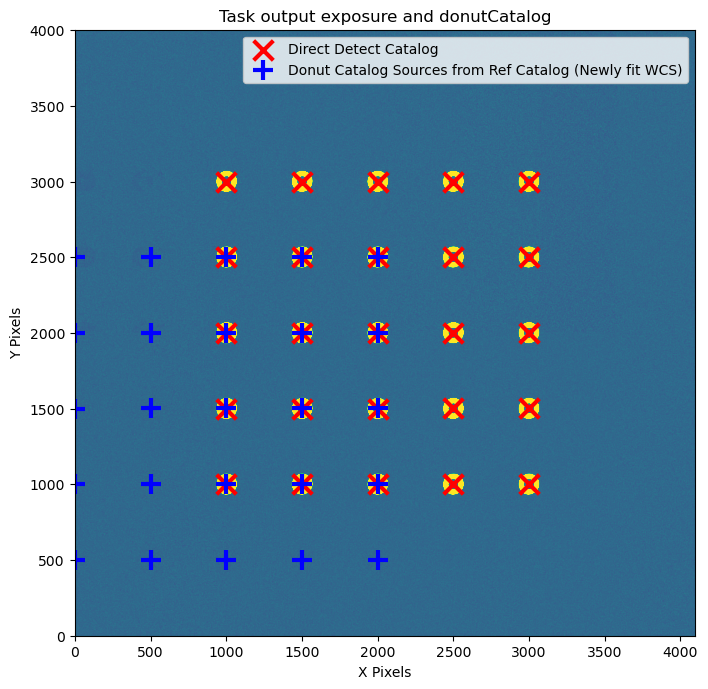

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

fig = plt.figure(figsize=(8,8))
data = postIsrExtra.image.array
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)

plt.imshow(postIsrExtra.image.array,  vmin=vmin, vmax=vmax, origin='lower')
plt.title('Task output exposure and donutCatalog')
plt.scatter(donutCatalog['centroid_x'], donutCatalog['centroid_y'], 
            c='r', marker='x', lw=3, s=200, label="Direct Detect Catalog")
plt.scatter(refCatOut['centroid_x'], refCatOut['centroid_y'],
            c='b', marker='+', lw=3, s=200, label="Donut Catalog Sources from Ref Catalog (Newly fit WCS)")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

??? Why is it offset like that?  

# Dev: stepping through elements of generateDonutFromRefitWcsTask

Step through elements of the task https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/generateDonutFromRefitWcsTask.py 

In [42]:
import typing
from copy import copy

import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.geom
import lsst.meas.base as measBase
import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
import lsst.pipe.base.connectionTypes as connectionTypes
import pandas as pd
from lsst.meas.algorithms import MagnitudeLimit, ReferenceObjectLoader
from lsst.meas.astrom import AstrometryTask, FitAffineWcsTask
from lsst.pipe.base.task import TaskError
from lsst.ts.wep.task.generateDonutCatalogUtils import (
    donutCatalogToDataFrame,
    runSelection,
)
from lsst.ts.wep.task.generateDonutCatalogWcsTask import (
    GenerateDonutCatalogWcsTask,
    GenerateDonutCatalogWcsTaskConfig,
)
from lsst.utils.timer import timeMethod

In [ ]:
from lsst.meas.astrom import As

In [43]:
def setDefaults(self):
    super().setDefaults()
    self.astromTask.wcsFitter.retarget(FitAffineWcsTask)
    self.astromTask.referenceSelector.doMagLimit = True
    magLimit = MagnitudeLimit()
    magLimit.minimum = 1
    magLimit.maximum = 15
    self.astromTask.referenceSelector.magLimit = magLimit
    self.astromTask.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
    self.astromTask.matcher.maxRotationDeg = 5.99
    self.astromTask.matcher.maxOffsetPix = 3000

First 


    def run(
            self,
            astromRefCat: typing.List[afwTable.SimpleCatalog],
            exposure: afwImage.Exposure,
            fitDonutCatalog: pd.DataFrame,
            photoRefCat: typing.List[afwTable.SimpleCatalog],
        ) -> pipeBase.Struct:
            astromRefObjLoader = ReferenceObjectLoader(
                dataIds=[ref.dataId for ref in astromRefCat],
                refCats=astromRefCat,
            )
            self.astromTask.setRefObjLoader(astromRefObjLoader)
            self.astromTask.refObjLoader.config.anyFilterMapsToThis = (
                self.config.anyFilterMapsToThis
            )
            afwCat = self.formatDonutCatalog(fitDonutCatalog)
            originalWcs = copy(exposure.wcs)

            successfulFit = False
            # Set a parameter in the metadata to
            # easily check whether the task ran WCS
            # fitting successfully or not. This will
            # give us information on our donut catalog output.
            self.metadata["wcsFitSuccess"] = False

        

In [46]:
astromRefCat = dataRefs
astromRefObjLoader = ReferenceObjectLoader(
            dataIds=[ref.dataId for ref in astromRefCat],
            refCats=astromRefCat,
        )

astromTask = AstrometryTask()
astromTask.setRefObjLoader(astromRefObjLoader)

astromTask.refObjLoader.config.anyFilterMapsToThis = (
            'g'
        )

In [49]:
# https://github.com/lsst-ts/ts_wep/blob/40ec61fbe672acbbc6a85afef4cbcfd08806281a/python/lsst/ts/wep/task/generateDonutCatalogWcsTask.py#L101
    
# When matching photometric filters are not available in
# the reference catalog (e.g. Gaia) use anyFilterMapsToThis
# to get sources out of the catalog.
anyFilterMapsToThis = LoadReferenceObjectsConfig.anyFilterMapsToThis

astromTask.refObjLoader.config.anyFilterMapsToThis = (
            'g'
        )
       

In [53]:
astromTask.refObjLoader.config

lsst.meas.algorithms.loadReferenceObjects.LoadReferenceObjectsConfig(pixelMargin=250, anyFilterMapsToThis='g', filterMap={}, requireProperMotion=False)

In [125]:
f = afwTable.Field['F'](name='alpha', doc = 'posdoc',
                       units='rad')

In [126]:
f

Field['F'](name="alpha", doc="posdoc", units="rad")

In [127]:
def formatDonutCatalog(catalog):
    """
    Create a minimal donut catalog in afwTable
    format from the input direct detect catalog.

    Parameters
    ----------
    catalog : `pandas.Dataframe`
        Catalog containing donut sources already detected
        on the exposure.

    Returns
    -------
    `lsst.afw.table.SimpleCatalog`
        Minimal catalog needed for astromeryTask to fit WCS.
    """

    sourceSchema = afwTable.SourceTable.makeMinimalSchema()
    measBase.SingleFrameMeasurementTask(schema=sourceSchema)  # expand the schema
    
    # add coord_raErr,  coord_decErr to the schema ... 
    sourceSchema.addField(afwTable.Field['F'](name="coord_raErr", doc="position err in ra",
                                             units='rad'),)
    sourceSchema.addField(afwTable.Field['F'](name="coord_decErr", doc="position err in dec"),)
    
    sourceCat = afwTable.SourceCatalog(sourceSchema)

    sourceCentroidKey = afwTable.Point2DKey(sourceSchema["slot_Centroid"])
    sourceIdKey = sourceSchema["id"].asKey()
    sourceRAKey = sourceSchema["coord_ra"].asKey()
    sourceDecKey = sourceSchema["coord_dec"].asKey()
    sourceInstFluxKey = sourceSchema["slot_ApFlux_instFlux"].asKey()
    sourceInstFluxErrKey = sourceSchema["slot_ApFlux_instFluxErr"].asKey()

   
    sourceRaErrKey = sourceSchema['coord_raErr'].asKey()
    sourceDecErrKey = sourceSchema['coord_decErr'].asKey()
    
    Nrows = len(catalog)
    sourceCat.reserve(Nrows)

    for i in range(Nrows):
        src = sourceCat.addNew()
        src.set(sourceIdKey, i)

        # set ra,dec
        ra = lsst.geom.Angle(catalog["coord_ra"].iloc[i], lsst.geom.radians)
        src.set(sourceRAKey, ra)

        dec = lsst.geom.Angle(catalog["coord_dec"].iloc[i], lsst.geom.radians)
        src.set(sourceDecKey, dec)
        
        # set default 1% for raErr, decErr
        raErr = ra*0.01
        src.set(sourceRaErrKey, raErr) 
        
        decErr = dec*0.01
        src.set(sourceDecErrKey, decErr) 
        
        # set the x,y centroid
        x = catalog["centroid_x"].iloc[i]
        y = catalog["centroid_y"].iloc[i]
        point = lsst.geom.Point2D(x, y)
        src.set(sourceCentroidKey, point)

        # set the flux and assume some small 1% flux error
        flux = catalog["source_flux"].iloc[i]
        src.set(sourceInstFluxKey, flux)

        fluxErr = flux / 100.0
        src.set(sourceInstFluxErrKey, fluxErr)

    return sourceCat

In [115]:
sourceSchema.addField?

In [74]:
sourceSchema.

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['D'](name="base_NaiveCentroid_x", doc="centroid from Naive Centroid algorithm", units="pixel"), Key<D>(offset=32, nElements=1)),
    (Field['D'](name="base_NaiveCentroid_y", doc="centroid from Naive Centroid algorithm", units="pixel"), Key<D>(offset=40, nElements=1)),
    (Field['Flag'](name="base_NaiveCentroid_flag", doc="General Failure Flag"), Key['Flag'](offset=48, bit=0)),
    (Field['Flag'](name="base_NaiveCentroid_flag_noCounts", doc="Object to be centroided has no counts"), Key['Flag'](offset=48, bit=1)),
    (Field['Flag'](name="base_NaiveCentroid_flag_edge", doc="Object too close to edg

In [117]:
sourceSchema.addField(afwTable.Field['F'](name="coord_raErr2", doc="position err in ra/dec"),
                     units='rad')

Key<F>(offset=644, nElements=1)

In [80]:
sourceRAerrKey = sourceSchema["coord_raErr"].asKey()

In [79]:
sourceSchema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['D'](name="base_NaiveCentroid_x", doc="centroid from Naive Centroid algorithm", units="pixel"), Key<D>(offset=32, nElements=1)),
    (Field['D'](name="base_NaiveCentroid_y", doc="centroid from Naive Centroid algorithm", units="pixel"), Key<D>(offset=40, nElements=1)),
    (Field['Flag'](name="base_NaiveCentroid_flag", doc="General Failure Flag"), Key['Flag'](offset=48, bit=0)),
    (Field['Flag'](name="base_NaiveCentroid_flag_noCounts", doc="Object to be centroided has no counts"), Key['Flag'](offset=48, bit=1)),
    (Field['Flag'](name="base_NaiveCentroid_flag_edge", doc="Object too close to edg

In [67]:
sourceSchema = afwTable.SourceTable.makeMinimalSchema()
measBase.SingleFrameMeasurementTask(schema=sourceSchema) 
sourceRaErrKey = sourceSchema['coord_raErr'].asKey()

NotFoundError: 
  File "include/lsst/afw/table/detail/SchemaImpl.h", line 93, in decltype(auto) lsst::afw::table::detail::SchemaImpl::findAndApply(const string&, F&&) const [with F = lsst::afw::table::{anonymous}::MakePythonSchemaItem&; std::string = std::__cxx11::basic_string<char>]
    Field with name 'coord_raErr' not found {0}
lsst::pex::exceptions::NotFoundError: 'Field with name 'coord_raErr' not found'


How is it that the `donutCatalog` has the `coord_ra` set with values, but then the `afwCatalog` has `NaN` there ? 

In [64]:
donutCatalog[:5]

,coord_ra,coord_dec,centroid_x,centroid_y,detector,source_flux,blend_centroid_x,blend_centroid_y
0,6.282700,-0.001015,1001.026407,1500.527925,R22_S11,3.452127e+06,[],[]
1,6.282700,-0.000530,1500.553774,1500.608168,R22_S11,3.450898e+06,[],[]
2,6.283184,-0.001015,1001.161533,1999.945247,R22_S11,3.449015e+06,[],[]
3,6.282700,-0.000046,2000.042955,1500.563171,R22_S11,3.448643e+06,[],[]
4,6.283184,-0.000530,1500.426140,2000.002621,R22_S11,3.448594e+06,[],[]


In [128]:
afwCat = formatDonutCatalog(donutCatalog)
afwCat.asAstropy()['coord_ra', 'coord_raErr']

coord_ra,coord_raErr
rad,rad
float64,float32
6.282699550986159,0.062827
6.282699628791556,0.062827
6.283183799648896,0.06283184
6.282699585161653,0.062827
6.283183855279924,0.06283184
6.28221538784176,0.062822156
0.00048292535695405804,4.8292536e-06
6.282215721040854,0.062822156


Well as soon as it's made it has the `coord_ra` , `coord_dec`... Do we need to just add small 1% error columns? 

In [100]:
afwCat = formatDonutCatalog(donutCatalog)

In [102]:
afwCat.asAstropy()[:4][['coord_ra', 'coord_raErr']]

coord_ra,coord_raErr
rad,rad
float64,float64
6.282699550986159,0.0628269955098616
6.282699628791556,0.06282699628791556
6.283183799648896,0.06283183799648896
6.282699585161653,0.06282699585161654


In [56]:
originalWcs = copy(postIsrExtra.wcs)

In [ ]:
ok, so it's while running the actual astrometry task that it complains that `coord_raErr` is not found ....

In [62]:
afwCat.asAstropy()

id,coord_ra,coord_dec,parent,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_near_edge,base_CircularApertureFlux_flag_badCentroid_near_edge,base_GaussianFlux_flag_badCentroid_near_edge,base_LocalBackground_flag_badCentroid_near_edge,base_NaiveCentroid_flag_badInitialCentroid_near_edge,base_PsfFlux_flag_badCentroid_near_edge,base_SdssShape_flag_badCentroid_near_edge,base_Variance_flag_badCentroid_near_edge,slot_Centroid_flag_near_edge,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blend

In [129]:
output_collection = 'run111'
data_id_intra = {'instrument': 'LSSTCam', 'exposure': 4021123106008, 'visit': 4021123106008, 'detector': 94}
data_id_extra = {'instrument': 'LSSTCam', 'exposure': 4021123106009, 'visit': 4021123106009, 'detector': 93}
postIsrExtra = butler.get('preFitPostISRCCD', dataId=data_id_intra, collections=output_collection)


astromRefCat = dataRefs
astromRefObjLoader = ReferenceObjectLoader(
            dataIds=[ref.dataId for ref in astromRefCat],
            refCats=astromRefCat,
        )

astromTask = AstrometryTask()
astromTask.setRefObjLoader(astromRefObjLoader)

astromTask.refObjLoader.config.anyFilterMapsToThis = (
            'g'
        )

In [130]:
wcs = postIsrExtra.getWcs()
originalWcs = copy(wcs)

That's the task https://github.com/lsst/meas_astrom/blob/main/python/lsst/meas/astrom/astrometry.py 

In [131]:
astromResult = astromTask.run(
                sourceCat=afwCat,
                exposure=postIsrExtra,
            )

INFO:lsst.astrometricSolver:Purged 0 sources, leaving 25 good sources
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [0.00000000, 360.00000000], [-0.13322201, 0.13322201] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 25 reference objects
INFO:lsst.astrometricSolver.referenceSelector:Selected 25/25 references
INFO:lsst.astrometricSolver.matcher:Matched 23 sources
INFO:lsst.astrometricSolver.matcher:Matched 23 sources
INFO:lsst.astrometricSolver.matcher:Matched 23 sources
INFO:lsst.astrometricSolver:Matched and fit WCS in 3 iterations; found 23 matches with mean and scatter = 0.026 +- 0.011 arcsec


In [104]:
astromTask.run.fit?

Object `astromTask.run.fit` not found.


# Run updated GenerateDonutFromRefitWcsTask on the auxTel data ...  

In [28]:
from copy import copy
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from scipy.spatial import cKDTree

# LSST imports
import lsst.geom
from lsst.daf.butler import Butler
from lsst.ts.wep.task import GenerateDonutDirectDetectTaskConfig, GenerateDonutDirectDetectTask
from lsst.ts.wep.task import RefCatalogInterface
from lsst.meas.algorithms import ReferenceObjectLoader, LoadReferenceObjectsConfig
from lsst.ts.wep.task import GenerateDonutFromRefitWcsTask, GenerateDonutFromRefitWcsTaskConfig
from lsst.ts.wep.task import GenerateDonutCatalogWcsTask, GenerateDonutCatalogWcsTaskConfig

%matplotlib inline

In [29]:
repo_dir = '/sdf/group/rubin/repo/embargo/'
butler = Butler(repo_dir)
output_collection = 'u/brycek/latiss_wep_test/run_all_full_catalog'
data_id_intra = {'instrument': 'LATISS', 'exposure': 2023031000223, 'visit': 2023031000223, 'detector': 0}
data_id_extra = {'instrument': 'LATISS', 'exposure': 2023031000224, 'visit': 2023031000224, 'detector': 0}
postIsrExtra = butler.get('postISRCCD', dataId=data_id_extra, collections=output_collection)
postIsrIntra = butler.get('postISRCCD', dataId=data_id_intra, collections=output_collection)


INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/s/scichris/.lsst/aws-credentials.ini


In [30]:
# Set configurations
config = GenerateDonutDirectDetectTaskConfig()
config.measurementTask.nSigmaDetection = 3. # The default used in the full run stored in the butler is 20.
config.initialCutoutPadding = 5

# Set auxTel parameters (see https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml for default auxtel instrument configuration).
config.instObscuration = 0.3525
config.instFocalLength = 21.6
config.instApertureDiameter = 1.2
config.instDefocalOffset = 32.8
config.instPixelSize = 10.0e-6
config.opticalModel = 'onAxis'

# Set donut selection parameters
config.donutSelector.useCustomMagLimit = True
config.donutSelector.unblendedSeparation = 160
config.donutSelector.maxBlended = 1
config.donutSelector.minBlendedSeparation = 0

In [31]:
camera = butler.get('camera', {'instrument': 'LATISS'}, collections='LATISS/calib/unbounded')
directDetectTask = GenerateDonutDirectDetectTask(config=config)
directDetectCat = directDetectTask.run(postIsrExtra, camera).donutCatalog

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 34 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 34 of 34 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 20/34 references


Text(0, 0.5, 'Y Pixels')

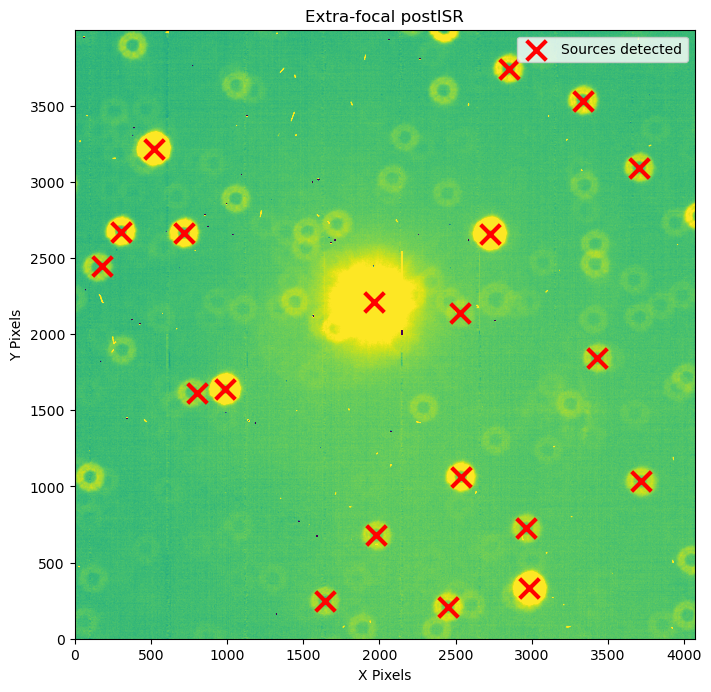

In [32]:
%matplotlib inline

fig=plt.figure(figsize=(8,8))

fig.add_subplot(1,1,1)
zscale_extra = ZScaleInterval().get_limits(postIsrExtra.image.array)
plt.imshow(postIsrExtra.image.array, 
           norm=mpl.colors.AsinhNorm(vmin=zscale_extra[0], 
                                     vmax=zscale_extra[1]), origin='lower')
plt.title('Extra-focal postISR')
plt.scatter(directDetectCat['centroid_x'], directDetectCat['centroid_y'], c='r', marker='x', lw=3, s=200, label="Sources detected")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

In [33]:
fitConfig = GenerateDonutFromRefitWcsTaskConfig()
# Set anyFilterMapsToThis for the astrometry catalog
fitConfig.anyFilterMapsToThis = 'phot_g_mean'
# Change the maximum offset in pixels allowed when fitting WCS
fitConfig.astromTask.matcher.maxOffsetPix = 1000
# Change the maximum magnitude for reference catalog sources allowed in `phot_g_mean_flux` band.
fitConfig.astromTask.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
fitConfig.astromTask.referenceSelector.magLimit.maximum = 15.0
# Configure the donut selection subtask
fitConfig.doDonutSelection = True
fitConfig.donutSelector.useCustomMagLimit = True
fitConfig.donutSelector.magMax = 16.0
fitConfig.donutSelector.unblendedSeparation = 160
fitConfig.donutSelector.minBlendedSeparation = 1
fitConfig.donutSelector.maxBlended = 3
# Initialize with pointing information
info = postIsrExtra.getInfo()
visitInfo = info.getVisitInfo()
boresightRa, boresightDec = visitInfo.boresightRaDec
boresightRotAng = visitInfo.boresightRotAngle

refCatInterface = RefCatalogInterface(boresightRa.asDegrees(), 
                                      boresightDec.asDegrees(), 
                                      boresightRotAng.asDegrees())
htmIds = refCatInterface.getHtmIds()
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
refCatButler = Butler('/sdf/data/rubin/repo/main/')
# Use Gaia for astrometry tasks
gaiaCatalogName = 'gaia_dr2_20200414'
collections = ['refcats/DM-28636']
gaiaDataRefs, gaiaDataIds = refCatInterface.getDataRefs(htmIds, refCatButler, gaiaCatalogName, collections)
gaiaRefCatConfig = LoadReferenceObjectsConfig(anyFilterMapsToThis='phot_g_mean')
gaiaRefCatLoader = ReferenceObjectLoader(gaiaDataIds, gaiaDataRefs, config=gaiaRefCatConfig)
gaiaRefCat = gaiaRefCatLoader.loadSkyCircle(visitInfo.boresightRaDec, lsst.geom.Angle(0.01), 'phot_g_mean')

htmIds = refCatInterface.getHtmIds()
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
refCatButler = Butler('/sdf/data/rubin/repo/main/')
ps1CatalogName = 'ps1_pv3_3pi_20170110'
collections = ['refcats/DM-28636']
ps1DataRefs, ps1DataIds = refCatInterface.getDataRefs(htmIds, refCatButler, ps1CatalogName, collections)
ps1RefCatConfig = LoadReferenceObjectsConfig(anyFilterMapsToThis='r')
ps1RefCatLoader = ReferenceObjectLoader(ps1DataIds, ps1DataRefs, config=ps1RefCatConfig)
ps1RefCat = ps1RefCatLoader.loadSkyCircle(visitInfo.boresightRaDec, lsst.geom.Angle(0.01), 'r')

INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [131.43932510, 132.91876680], [-39.80677740, -38.66085838] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 70832 reference objects
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [131.43932510, 132.91876680], [-39.80677740, -38.66085838] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 25194 reference objects


In [34]:
fitTask = GenerateDonutFromRefitWcsTask(config=fitConfig)
out = fitTask.run(gaiaDataRefs, copy(postIsrExtra), directDetectCat, ps1DataRefs)

INFO:lsst.generateDonutFromRefitWcsTask.astromTask:Purged 0 sources, leaving 20 good sources
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loading reference objects from None in region bounded by [132.06787916, 132.28875716], [-39.32102114, -39.14920888] RA Dec
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Loaded 1063 reference objects
INFO:lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader:Correcting reference catalog for proper motion to <Time object: scale='tai' format='mjd' value=60014.117485839044>
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.referenceSelector:Selected 26/1063 references
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.matcher:Matched 12 sources
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.matcher:Matched 11 sources
INFO:lsst.generateDonutFromRefitWcsTask.astromTask.matcher:Matched 11 sources
INFO:lsst.generateDonutFromRefitWcsTask.astromTask:Matched and fit WCS in 3 iterations; found 11 matc

In [35]:
expNew = out.outputExposure
refCatOut = out.donutCatalog


In [36]:
expNew.wcs

FITS standard SkyWcs:
Sky Origin: (132.1790459507, -39.2338178907)
Pixel Origin: (1951.55, 2194.5)
Pixel Scale: 0.095632 arcsec/pixel

I notice that here the new WCS is much shifted in origin to the original WCS, much more than in the example notebook, even though it's using the identical data.. Perhaps 1% error is too much on the original raErr?  

vs the original WCS:

In [43]:
postIsrExtra.wcs

FITS standard SkyWcs:
Sky Origin: (132.1790459507, -39.2338178907)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [39]:
refCatOut[:4]

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,2.306954,-0.684757,1951.799981,2205.711581,5.258068e+09,[],[]
1,2.306011,-0.685116,517.923453,3215.510735,9.899792e+07,[],[]
2,2.306938,-0.684342,2724.129399,2656.442859,7.211508e+07,[],[]
3,2.308235,-0.684751,2986.883758,332.102717,3.429462e+07,[],[]


Text(0, 0.5, 'Y Pixels')

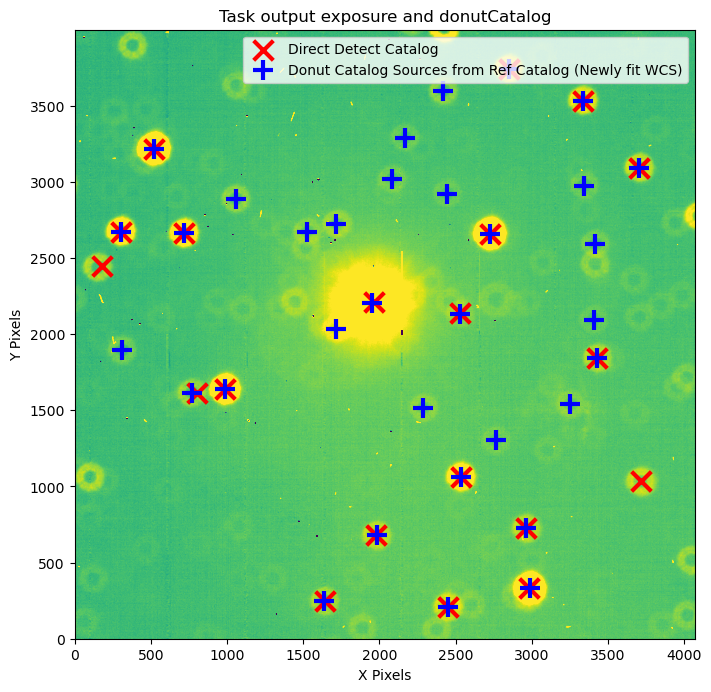

In [40]:
fig = plt.figure(figsize=(8,8))
zscale_extra = ZScaleInterval().get_limits(postIsrExtra.image.array)
plt.imshow(postIsrExtra.image.array, norm=mpl.colors.AsinhNorm(vmin=zscale_extra[0], vmax=zscale_extra[1]), origin='lower')
plt.title('Task output exposure and donutCatalog')
plt.scatter(directDetectCat['centroid_x'], directDetectCat['centroid_y'], c='r', marker='x', lw=3, s=200, label="Direct Detect Catalog")
plt.scatter(refCatOut['centroid_x'], refCatOut['centroid_y'], c='b', marker='+', lw=3, s=200, label="Donut Catalog Sources from Ref Catalog (Newly fit WCS)")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

compare to direct detect ... 

In [41]:
# Examine WCS fit offsets from detected catalog by running a crossmatch with a kdtree
kdtree = cKDTree(directDetectCat[['centroid_x', 'centroid_y']].values)
dist, ind = kdtree.query(refCatOut[['centroid_x', 'centroid_y']].values, k=1, distance_upper_bound=40.)

refCatIdx = np.where(dist != np.inf)[0]
directDetectIdx = ind[refCatIdx]

Text(0.5, 0, 'Total Pixel offset (refCat - directDetect)')

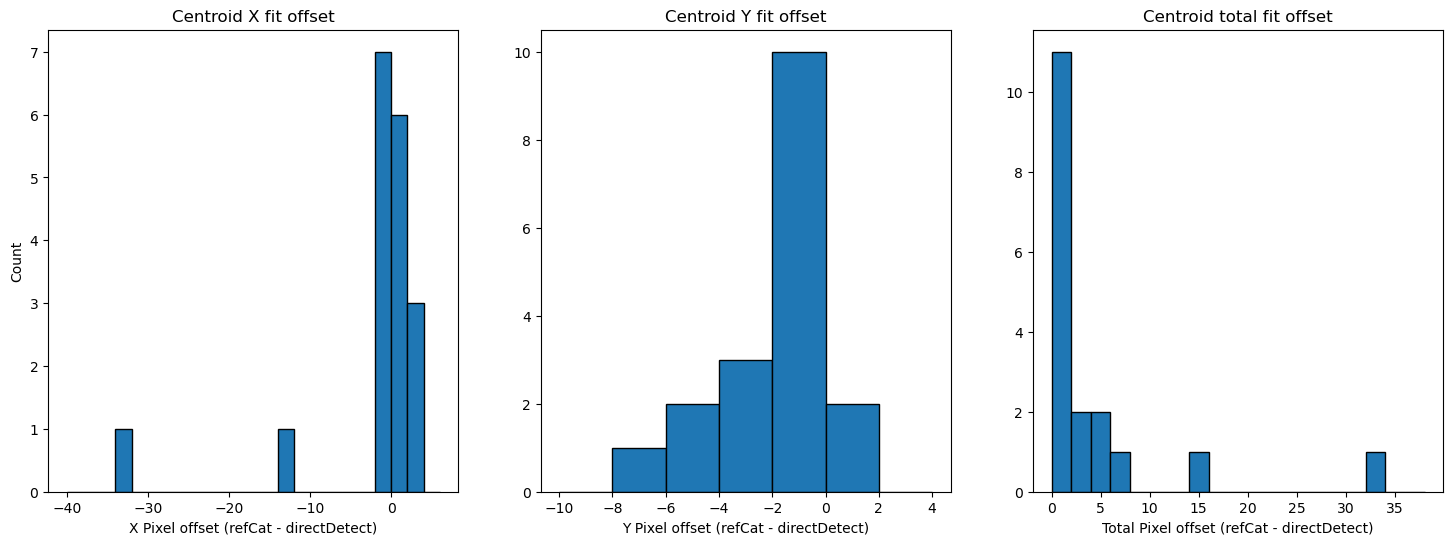

In [42]:
fig = plt.figure(figsize=(18, 6))
fig.add_subplot(1,3,1)
plt.hist(refCatOut['centroid_x'].values[refCatIdx] - directDetectCat['centroid_x'].values[directDetectIdx], bins=np.arange(-40, 7, 2), edgecolor="black")
plt.title('Centroid X fit offset')
plt.xlabel('X Pixel offset (refCat - directDetect)')
plt.ylabel('Count')

fig.add_subplot(1,3,2)
plt.hist(refCatOut['centroid_y'].values[refCatIdx] - directDetectCat['centroid_y'].values[directDetectIdx], bins=np.arange(-10, 5, 2), edgecolor="black")
plt.title('Centroid Y fit offset')
plt.xlabel('Y Pixel offset (refCat - directDetect)')

fig.add_subplot(1,3,3)
plt.hist(
    np.sqrt((refCatOut['centroid_y'].values[refCatIdx] - directDetectCat['centroid_y'].values[directDetectIdx])**2 + (refCatOut['centroid_x'].values[refCatIdx] - directDetectCat['centroid_x'].values[directDetectIdx])**2),
    bins=np.arange(0, 40, 2),
    edgecolor="black"
)
plt.title('Centroid total fit offset')
plt.xlabel('Total Pixel offset (refCat - directDetect)')